In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)
from tsai.all import *
import sklearn.metrics as skm
import sys
from sklearn.model_selection import train_test_split
import numpy as np
import random
import importlib

# import outsiders
sys.path.append('../pre_processing_and_recover_network/')
import data_preprocessing
importlib.reload(data_preprocessing)

sys.path.append('../pytorch_model')
import ECG
importlib.reload(ECG)

In [ ]:
# prepare the data
def split_data_indexes(len_data, train_ratio):
    indexes = list(range(len_data))
    random.shuffle(indexes)
    train_size = int(len_data * train_ratio)
    train_indexes = indexes[:train_size]
    test_indexes = indexes[train_size:]
    return (train_indexes, test_indexes)
# ssh remote
swell_data = data_preprocessing.load_data(os.path.join("../pre_processing_and_recover_network/swell_dataset/","swell_dict.npy"))
swell_data = data_preprocessing.swell_prepare_for_10fold(swell_data)
swell_data[:, 1:4] -= 1
x = swell_data[:, 4:]

y_arousal = swell_data[:, 2]
y_arousal = y_arousal.reshape(y_arousal.shape[0],)

y_valence = swell_data[:, 3]
y_valence = y_valence.reshape(y_valence.shape[0],)

y_stress = swell_data[:, 1]
y_stress = y_stress.reshape(y_stress.shape[0],)

print(x.shape)
print(type(x))
print(y_stress.shape)
print(y_valence.shape)
print(y_arousal.shape)


# set X to 3-Dim array
x = np.array(x)
x = np.expand_dims(x, axis=1)
print(x.shape)
filename = 'X_memmap.npy'
X = np.memmap(filename, dtype='float32', mode='w+', shape=x.shape)
X[:] = x[:]
print(X.shape)
print(type(X))

filename = 'Y_arousal_memmap.npy'
Y_arousal = np.memmap(filename, dtype='float32', mode='w+', shape=y_arousal.shape)
Y_arousal[:] = y_arousal[:]

filename = 'Y_valence_memmap.npy'
Y_valence = np.memmap(filename, dtype='float32', mode='w+', shape=y_valence.shape)
Y_valence[:] = y_valence[:]

filename = 'Y_stress_memmap.npy'
Y_stress = np.memmap(filename, dtype='float32', mode='w+', shape=y_stress.shape)
Y_stress[:] = y_stress[:]
print(Y_stress.shape)
print(type(Y_stress))
splits=split_data_indexes(X.shape[0],0.9)
print(len(splits[0]))
print(len(splits[1]))

**For randomal splits**

In [3]:
splits=np.load('./splits_A.npy',allow_pickle=True)
path='./model_light_250.pt'
 

**For spliting subjests for Train and Test**

In [3]:
splits=np.load('./splits_B.npy',allow_pickle=True)
path='./model_light_250_B.pt' 

In [ ]:
model_recovered=ECG.EmotionRec()
model_recovered.load_state_dict(torch.load(path))
model_recovered.eval()
CNN=model_recovered.cnn
tmp=swell_data[:, 4:]
input=torch.from_numpy(tmp).float().unsqueeze(1)
out=CNN.forward(input)
print(out.shape)
out2=out.detach().numpy()
print((out2).shape)
out3=np.transpose(out2,(0,2,1))
print(out3.shape)
filename = 'X_memmap.npy'
X = np.memmap(filename, dtype='float32', mode='w+', shape=out3.shape)
X[:] = out3[:]
print(X.shape)
print(type(X))

**Prepare dataset loaders and model**

In [7]:
#splits=split_data_indexes(X.shape[0],0.9) for using local
splits=(splits[0],splits[1])

dsets_arousal = TSDatasets(X, Y_arousal, tfms=[None, [Categorize()]], splits=splits, inplace=True)
dsets_valence = TSDatasets(X, Y_valence, tfms=[None, [Categorize()]], splits=splits, inplace=True)
dsets_stress = TSDatasets(X, Y_stress, tfms=[None, [Categorize()]], splits=splits, inplace=True)

bs=128
dls_stress = TSDataLoaders.from_dsets(dsets_stress.train, dsets_stress.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)
dls_arousal = TSDataLoaders.from_dsets(dsets_arousal.train, dsets_arousal.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)
dls_valence = TSDataLoaders.from_dsets(dsets_valence.train, dsets_valence.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)

c_in=1
c_out_stress=3
c_out_arousal=9
c_out_valence=9
seq_len=128
n_heads=4
n_layers=4
act='relu'
max_seq_len=None
d_model=32
fc_dropout=0.1
d_ff=32
d_v=32
d_k=32
conv={"kernel_size":30,"stride":1}

model_stress = TST(c_in=c_in, c_out=c_out_stress, seq_len=seq_len, n_heads=n_heads, n_layers=n_layers,act=act,
    max_seq_len=max_seq_len,d_model=d_model,fc_dropout=fc_dropout,d_ff=d_ff,d_v=d_v,d_k=d_k)
model_arousal = TST(c_in=c_in, c_out=c_out_arousal, seq_len=seq_len, n_heads=n_heads, n_layers=n_layers,act=act,
    max_seq_len=max_seq_len,d_model=d_model,fc_dropout=fc_dropout,d_ff=d_ff,d_v=d_v,d_k=d_k)
model_valence = TST(c_in=c_in, c_out=c_out_valence, seq_len=seq_len, n_heads=n_heads, n_layers=n_layers,act=act,
    max_seq_len=max_seq_len,d_model=d_model,fc_dropout=fc_dropout,d_ff=d_ff,d_v=d_v,d_k=d_k)

learn_stress = Learner(dls_stress, model_stress, metrics=accuracy)
learn_arousal = Learner(dls_arousal, model_arousal, metrics=accuracy)
learn_valence = Learner(dls_valence, model_valence, metrics=accuracy)

learn_stress.save('S-0')
learn_arousal.save('S0')
learn_valence.save('S0')

Path('models/S0.pth')

In [ ]:
print(model_stress)

**Train for stress**

SuggestedLRs(valley=0.0002754228771664202)

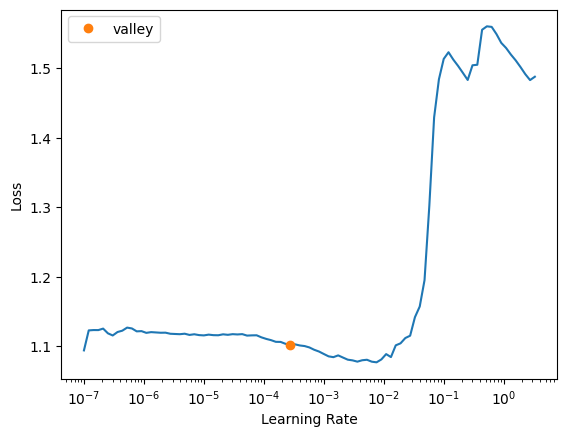

In [8]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)
learn_stress.load('S-0')
learn_stress.lr_find()

In [ ]:
learn_stress.load('S-0')
learn_stress.fit_one_cycle(100,lr_max=1e-3)
learn_stress.save('S-1') 

In [113]:
learn_stress.save_all(path='./TST_params/Stress', dls_fname='dls_stress', model_fname='model_stress', learner_fname='learner_stress')

**Train for arousal**

In [7]:
learn_arousal.load('S0')
learn_arousal.lr_find()

SuggestedLRs(valley=0.00015848931798245758)

In [ ]:
#learn_arousal.load('S0')
learn_arousal.fit_one_cycle(100,lr_max=1e-4)
learn_arousal.save('S1')

In [117]:
learn_arousal.save_all(path='./TST_params/Arousal', dls_fname='dls_arousal', model_fname='model_arousal', learner_fname='learner_arousal')

**Train for valence**

In [118]:
learn_valence.load('S0')
learn_valence.lr_find()

SuggestedLRs(valley=0.00015848931798245758)

In [ ]:
learn_valence.fit_one_cycle(100,lr_max=1e-4)
learn_valence.save('S1')

In [120]:
learn_valence.save_all(path='./TST_params/Valence', dls_fname='dls_valence', model_fname='model_valence', learner_fname='learner_valence')

In [121]:
np.save('./TST_params/splits_TST_2504',splits)

**not same objcets in train and test**

In [7]:
def train_test_indexes_var2(ratio, objects):
    # Split objects into train and test sets
    num_test = int(len(set(objects)))-int(len(set(objects)) * ratio)
    obj_list = list(set(objects))
    random.shuffle(obj_list)
    test_objs = obj_list[:num_test]
    train_objs = obj_list[num_test:]

    train_idxs = []
    test_idxs = []

    # Assign each object's samples to the appropriate set
    for obj in train_objs:
        obj_idxs = [i for i, o in enumerate(objects) if o == obj]
        train_idxs.extend(obj_idxs)

    for obj in test_objs:
        obj_idxs = [i for i, o in enumerate(objects) if o == obj]
        test_idxs.extend(obj_idxs)

    # Shuffle the final train and test sets
    random.shuffle(train_idxs)
    random.shuffle(test_idxs)

    return (train_idxs), (test_idxs)

In [8]:
# check train_test_indexes_var2()
# not for each runnig acieve exaclty 9:1 train:test
ratio = 0.9
objects=swell_data[:,0]
print("tot len is ", len(objects))
print("trin len is ",ratio*len(objects))
print("test len is ",len(objects)-ratio*len(objects))
i=train_test_indexes_var2(ratio, objects)
#print("train idx ",i[0])
#print("test idx ",i[1])
print("train obj:")
tr=[]
for j in i[0]:
  #print(objects[int(j)])
  tr.append(objects[int(j)])
tr_u=set(tr)

print("test obj:")
te=[]
for j in i[1]:
  #print(objects[int(j)])
  te.append(objects[int(j)])
te_u=set(te)

print(tr_u,len(tr))
print(te_u,len(te))
splits=i

tot len is  14595
trin len is  13135.5
test len is  1459.5
train obj:
test obj:
{1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 9.0, 10.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0} 12656
{25.0, 12.0, 5.0} 1939


In [9]:
tfms  = [None, [Categorize()]]

dsets_arousal = TSDatasets(X, Y_arousal, tfms=tfms, splits=splits, inplace=True)
dsets_valence = TSDatasets(X, Y_valence, tfms=tfms, splits=splits, inplace=True)
dsets_stress = TSDatasets(X, Y_stress, tfms=tfms, splits=splits, inplace=True)

bs=128
dls_stress = TSDataLoaders.from_dsets(dsets_stress.train, dsets_stress.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)
dls_arousal = TSDataLoaders.from_dsets(dsets_arousal.train, dsets_arousal.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)
dls_valence = TSDataLoaders.from_dsets(dsets_valence.train, dsets_valence.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)

c_in=1
c_out_stress=3
c_out_arousal=9
c_out_valence=9
seq_len=128
n_heads=4
n_layers=4
act='relu'
max_seq_len=None
d_model=32
fc_dropout=0.1
d_ff=32
d_v=32
d_k=32
conv={"kernel_size":30,"stride":1}

model_stress = TST(c_in=c_in, c_out=c_out_stress, seq_len=seq_len, n_heads=n_heads, n_layers=n_layers,act=act,
    max_seq_len=max_seq_len,d_model=d_model,fc_dropout=fc_dropout,d_ff=d_ff,d_v=d_v,d_k=d_k)
model_arousal = TST(c_in=c_in, c_out=c_out_arousal, seq_len=seq_len, n_heads=n_heads, n_layers=n_layers,act=act,
    max_seq_len=max_seq_len,d_model=d_model,fc_dropout=fc_dropout,d_ff=d_ff,d_v=d_v,d_k=d_k)
model_valence = TST(c_in=c_in, c_out=c_out_valence, seq_len=seq_len, n_heads=n_heads, n_layers=n_layers,act=act,
    max_seq_len=max_seq_len,d_model=d_model,fc_dropout=fc_dropout,d_ff=d_ff,d_v=d_v,d_k=d_k)

learn_stress = Learner(dls_stress, model_stress, metrics=accuracy)
learn_arousal = Learner(dls_arousal, model_arousal, metrics=accuracy)
learn_valence = Learner(dls_valence, model_valence, metrics=accuracy)

learn_stress.save('S-0')
learn_arousal.save('S0')
learn_valence.save('S0')

Path('models/S0.pth')

**Train for Stress**

In [13]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)
learn_stress.load('S-0')
learn_stress.lr_find()

SuggestedLRs(valley=0.0002290867705596611)

In [14]:
learn_stress.load('S-0')
learn_stress.fit_one_cycle(100,lr_max=1e-4)
learn_stress.save('S-1')

epoch,train_loss,valid_loss,accuracy,time
0,1.093876,0.955346,0.663744,00:01
1,1.061233,0.928190,0.689531,00:01
2,1.045704,0.903355,0.685921,00:01
3,1.029113,0.899999,0.680763,00:01
4,1.009356,0.879660,0.654977,00:01
5,0.989800,0.869397,0.594636,00:01
6,0.965325,0.882246,0.562145,00:01
7,0.931627,0.884251,0.511604,00:01
8,0.901143,0.905412,0.478597,00:01
9,0.862510,0.927644,0.484270,00:01


Path('models/S-1.pth')